### Test the trained VPTR

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime
import time

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights, VPTRFormerFAR, VPTRFormerNAR
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training, write_code_files
from utils import set_seed, PSNR, SSIM, MSEScore, get_dataloader
import lpips
import numpy as np


from matplotlib import pyplot as plt

set_seed(2021)

c:\Users\sc23gd\.conda\envs\VPTR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
resume_ckpt = Path("C:\VPTR_jigsaws_modifications\jigsaws_suturing\JIGSAWS_NAR_MSEGDLgan_ckpt\epoch_1058.tar") #The trained Transformer checkpoint file
resume_AE_ckpt = Path('C:\\VPTR_jigsaws_modifications\\jigsaws_suturing\\JIGSAWS_ResNetAE_MSEGDLgan_ckpt\\BAIR_AE.tar') #The trained AutoEncoder checkpoint file
# Load the checkpoint
checkpoint = torch.load(resume_ckpt)
num_past_frames = 2
num_future_frames = 10
encH, encW, encC = 8, 8, 528
TSLMA_flag = False
rpe = True
model_flag = 'NAR' #'NAR' for NAR model, 'FAR' for FAR model

img_channels = 3 # 1 for KTH and MovingMNIST, 3 for BAIR
N = 32
device = torch.device('cuda:0')
loss_name_list = ['T_MSE', 'T_GDL', 'T_gan', 'T_total', 'Dtotal', 'Dfake', 'Dreal']

In [3]:
#Set the padding_type to be "zero" for BAIR dataset
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3, padding_type = 'zero').to(device) 

#Set the padding_type to be "zero" for BAIR dataset, set the out_layer to be 'Sigmoid' for MovingMNIST
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Tanh', padding_type = 'zero').to(device) 
VPTR_Enc = VPTR_Enc.eval()
VPTR_Dec = VPTR_Dec.eval()

if model_flag == 'NAR':
    VPTR_Transformer = VPTRFormerNAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                         nhead=8, num_encoder_layers=4, num_decoder_layers=8, dropout=0.1, 
                                         window_size=4, Spatial_FFN_hidden_ratio=4, TSLMA_flag = TSLMA_flag, rpe=rpe).to(device)
else:
    VPTR_Transformer = VPTRFormerFAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                    nhead=16, num_encoder_layers=24, dropout=0.1, 
                                    window_size=2, Spatial_FFN_hidden_ratio=8, rpe=rpe).to(device)

VPTR_Transformer = VPTR_Transformer.eval()

#load the trained autoencoder, we initialize the discriminator from scratch, for a balanced training
loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, {}, resume_AE_ckpt, loss_name_list)
if resume_ckpt is not None:
    loss_dict, start_epoch = resume_training({'VPTR_Transformer': VPTR_Transformer}, 
                                             {}, resume_ckpt, loss_name_list)

c:\Users\sc23gd\.conda\envs\VPTR\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
_, _, test_loader, renorm_transform = get_dataloader('BAIR', N, 'C:\\VPTR_jigsaws_working\\jigsaws_suturing\\bair_format_dir', test_past_frames = 2, test_future_frames = 10, ngpus = 1, num_workers = 0)

In [5]:
# Get a batch of images from the test_loader
images, _ = next(iter(test_loader))

# Print the shape of the images
print(images.shape)

torch.Size([32, 2, 3, 64, 64])


In [6]:
# Get the first image in the batch
image = images[0]

# Print the shape of the individual image
print(image.shape)

torch.Size([2, 3, 64, 64])


In [7]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    """
    Plot and save figure
    """
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img, cmap = 'gray')
    fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')
    
def FAR_RIL_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over Latent space, get a worse result
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = pred_feats[:, -1:, ...]
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def FAR_RIP_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over pixel space
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = VPTR_Enc(pred_future_frame)
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    NAR model inference function, for the case num_pred is divisible for the num_future_frames of training. e.g. num_pred = 20, num_future_frames = 10
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    past_gt_feats = VPTR_Enc(past_frames)
    
    for i in range(0, num_pred//VPTR_Transformer.num_future_frames):
        pred_future_feats = VPTR_Transformer(past_gt_feats)
        if i == 0:
            pred_frames = VPTR_Dec(pred_future_feats)
        else:
            pred_frames = torch.cat([pred_frames, VPTR_Dec(pred_future_feats)], dim = 1)
        past_gt_feats = pred_future_feats
        
    
    return pred_frames, future_frames


def NAR_BAIR_2_to_28_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    Specifically for BAIR dataset, 2 -> 28 prediction.
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    #assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    pred = []
    #prediction 1
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    #prediction 2
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    
    #prediction 3
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames[:, 0:-2, ...])
    pred_frames = torch.cat(pred, dim = 1)
    
    return pred_frames, future_frames         

In [8]:
sample = next(iter(test_loader))
num_pred = 10
with torch.no_grad():
    past_frames, future_frames = sample
    print(f"future_frames.shape: {future_frames.shape}")
    pred_frames, gt_frames = NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)

future_frames.shape: torch.Size([32, 10, 3, 64, 64])


In [26]:
# sample = next(iter(test_loader))
# num_pred = 10
# with torch.no_grad():
#     pred_frames, gt_frames = NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)


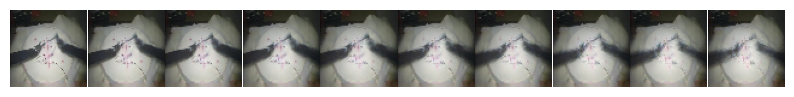

In [9]:
plot_model_result(pred_frames, 'pred_nar_bair', 10, n = 5)

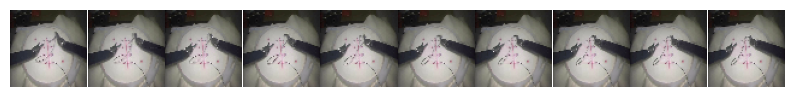

In [10]:
plot_model_result(gt_frames, 'gt_bair', 10, n = 5)

In [11]:
# Create the complete model for metric evaluation
model = nn.Sequential(VPTR_Enc, VPTR_Transformer, VPTR_Dec)

In [12]:
import numpy as np
from utils import PSNR, SSIM
import lpips
from tqdm import tqdm 

def pred_ave_metrics(model, data_loader, renorm_transform, num_future_frames, num_past_frames, device='cuda:0'): 
    model = model.to(device)
    model = model.eval()
    ave_psnr = np.zeros(num_future_frames)
    ave_ssim = np.zeros(num_future_frames) 
    ave_lpips = np.zeros(num_future_frames) 
    sample_num = 0

    loss_fn_alex = lpips.LPIPS(net='alex').to(device) # Initialize LPIPS model

    with torch.no_grad():
        for idx, sample in enumerate(tqdm(data_loader), 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)

            # Calculate PSNR
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                pred_t = renorm_transform(pred_t)
                future_frames_t = renorm_transform(future_frames_t)

                ave_psnr[i] += PSNR(pred_t, future_frames_t) * pred_t.shape[0]

            # Calculate SSIM
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                pred_t = renorm_transform(pred_t)
                future_frames_t = renorm_transform(future_frames_t)

                ave_ssim[i] += SSIM(pred_t, future_frames_t) * pred_t.shape[0]

            # Calculate LPIPS
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                # LPIPS expects 3-channel images
                if pred_t.shape[1] == 1:  # If grayscale, repeat channels
                    pred_t = pred_t.repeat(1, 3, 1, 1)
                    future_frames_t = future_frames_t.repeat(1, 3, 1, 1) 
                
                ave_lpips[i] += loss_fn_alex(pred_t, future_frames_t).mean().item() * pred_t.shape[0]

            sample_num += pred.shape[0]

    ave_psnr = ave_psnr / sample_num
    ave_ssim = ave_ssim / sample_num
    ave_lpips = ave_lpips / sample_num
    return ave_psnr, ave_ssim, ave_lpips  # Return all three metrics

  0%|          | 0/43 [00:00<?, ?it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  2%|▏         | 1/43 [00:01<00:52,  1.25s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  5%|▍         | 2/43 [00:02<00:48,  1.19s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  7%|▋         | 3/43 [00:03<00:46,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  9%|▉         | 4/43 [00:04<00:44,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 12%|█▏        | 5/43 [00:05<00:42,  1.13s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 14%|█▍        | 6/43 [00:06<00:41,  1.12s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 16%|█▋        | 7/43 [00:07<00:40,  1.11s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 19%|█▊        | 8/43 [00:09<00:38,  1.10s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 21%|██        | 9/43 [00:10<00:37,  1.11s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 23%|██▎       | 10/43 [00:11<00:36,  1.12s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 26%|██▌       | 11/43 [00:12<00:35,  1.11s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 28%|██▊       | 12/43 [00:13<00:34,  1.12s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 30%|███       | 13/43 [00:14<00:33,  1.11s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 33%|███▎      | 14/43 [00:15<00:32,  1.12s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 35%|███▍      | 15/43 [00:16<00:31,  1.11s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 37%|███▋      | 16/43 [00:17<00:30,  1.11s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 40%|███▉      | 17/43 [00:19<00:29,  1.12s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 42%|████▏     | 18/43 [00:20<00:27,  1.11s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 44%|████▍     | 19/43 [00:21<00:27,  1.13s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 47%|████▋     | 20/43 [00:22<00:28,  1.22s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 49%|████▉     | 21/43 [00:24<00:29,  1.36s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 51%|█████     | 22/43 [00:25<00:26,  1.28s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 53%|█████▎    | 23/43 [00:26<00:24,  1.23s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 56%|█████▌    | 24/43 [00:27<00:22,  1.19s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 58%|█████▊    | 25/43 [00:28<00:21,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 60%|██████    | 26/43 [00:29<00:19,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 63%|██████▎   | 27/43 [00:31<00:18,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 65%|██████▌   | 28/43 [00:32<00:17,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 67%|██████▋   | 29/43 [00:33<00:16,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 70%|██████▉   | 30/43 [00:35<00:17,  1.36s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 72%|███████▏  | 31/43 [00:36<00:15,  1.29s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 74%|███████▍  | 32/43 [00:37<00:13,  1.24s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 77%|███████▋  | 33/43 [00:38<00:12,  1.21s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 79%|███████▉  | 34/43 [00:39<00:10,  1.19s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 81%|████████▏ | 35/43 [00:40<00:09,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 84%|████████▎ | 36/43 [00:42<00:08,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 86%|████████▌ | 37/43 [00:43<00:06,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 88%|████████▊ | 38/43 [00:44<00:05,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 91%|█████████ | 39/43 [00:45<00:04,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 93%|█████████▎| 40/43 [00:46<00:03,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 95%|█████████▌| 41/43 [00:47<00:02,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 98%|█████████▊| 42/43 [00:48<00:01,  1.12s/it]

Prediction shape: torch.Size([22, 10, 3, 64, 64])


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


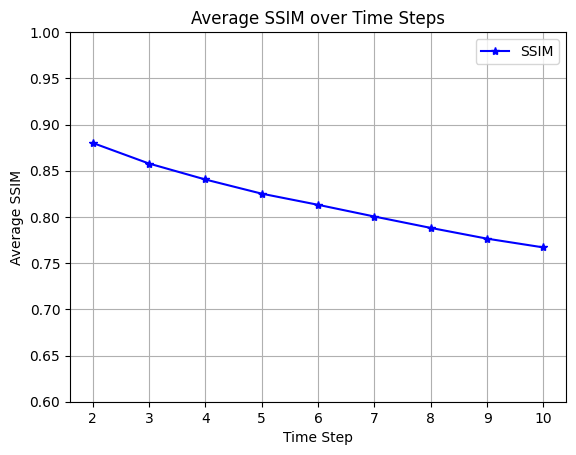

In [36]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def calculate_average_ssim(model, data_loader, renorm_transform, num_future_frames, device='cuda:0'):
    model = model.to(device)
    model = model.eval()
    ave_ssim = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(tqdm(data_loader), 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            print(f"Prediction shape: {pred.shape}")  # Debug
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                pred_t = renorm_transform(pred_t)
                future_frames_t = renorm_transform(future_frames_t)

                ssim_value = ssim(pred_t.cpu().numpy(), future_frames_t.cpu().numpy(), win_size=3, multichannel=True, data_range=1.0, channel_axis=0)
                ave_ssim[i] += ssim_value * pred_t.shape[0]

            sample_num += pred.shape[0]

    ave_ssim = ave_ssim / sample_num
    return ave_ssim

num_future_frames = 10  # Adjusted to match model output

# Assuming you have a test_loader and renorm_transform defined
average_ssim = calculate_average_ssim(
    model=model,
    data_loader=test_loader,
    renorm_transform=renorm_transform,
    num_future_frames=num_future_frames,  # Adjusted to match model output
    device='cuda:0'
)

# Plot SSIM results for the time steps 2 to 10
time_steps = np.arange(2, 11)  # Time steps from 2 to 10
plt.plot(time_steps, average_ssim[1:10], marker='*', linestyle='-', color='b', label='SSIM') # <--- Slice average_ssim to 9 values
plt.xlabel('Time Step')
plt.ylabel('Average SSIM')
plt.title('Average SSIM over Time Steps')
plt.ylim([0.6, 1.0]) 
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/43 [00:00<?, ?it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  2%|▏         | 1/43 [00:01<00:49,  1.18s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  5%|▍         | 2/43 [00:02<00:47,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  7%|▋         | 3/43 [00:03<00:46,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  9%|▉         | 4/43 [00:04<00:45,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 12%|█▏        | 5/43 [00:05<00:44,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 14%|█▍        | 6/43 [00:06<00:42,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 16%|█▋        | 7/43 [00:08<00:41,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 19%|█▊        | 8/43 [00:09<00:40,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 21%|██        | 9/43 [00:10<00:38,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 23%|██▎       | 10/43 [00:11<00:37,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 26%|██▌       | 11/43 [00:12<00:36,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 28%|██▊       | 12/43 [00:13<00:35,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 30%|███       | 13/43 [00:14<00:34,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 33%|███▎      | 14/43 [00:16<00:33,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 35%|███▍      | 15/43 [00:17<00:32,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 37%|███▋      | 16/43 [00:18<00:30,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 40%|███▉      | 17/43 [00:19<00:29,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 42%|████▏     | 18/43 [00:20<00:28,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 44%|████▍     | 19/43 [00:21<00:28,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 47%|████▋     | 20/43 [00:23<00:26,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 49%|████▉     | 21/43 [00:24<00:25,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 51%|█████     | 22/43 [00:25<00:24,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 53%|█████▎    | 23/43 [00:26<00:23,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 56%|█████▌    | 24/43 [00:27<00:21,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 58%|█████▊    | 25/43 [00:28<00:20,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 60%|██████    | 26/43 [00:30<00:19,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 63%|██████▎   | 27/43 [00:31<00:18,  1.16s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 65%|██████▌   | 28/43 [00:32<00:17,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 67%|██████▋   | 29/43 [00:33<00:16,  1.15s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 70%|██████▉   | 30/43 [00:34<00:15,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 72%|███████▏  | 31/43 [00:35<00:14,  1.18s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 74%|███████▍  | 32/43 [00:37<00:13,  1.19s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 77%|███████▋  | 33/43 [00:38<00:11,  1.18s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 79%|███████▉  | 34/43 [00:39<00:10,  1.18s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 81%|████████▏ | 35/43 [00:40<00:09,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 84%|████████▎ | 36/43 [00:41<00:08,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 86%|████████▌ | 37/43 [00:42<00:07,  1.18s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 88%|████████▊ | 38/43 [00:44<00:05,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 91%|█████████ | 39/43 [00:45<00:04,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 93%|█████████▎| 40/43 [00:46<00:03,  1.17s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 95%|█████████▌| 41/43 [00:48<00:02,  1.28s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 98%|█████████▊| 42/43 [00:49<00:01,  1.44s/it]

Prediction shape: torch.Size([22, 10, 3, 64, 64])


100%|██████████| 43/43 [00:50<00:00,  1.18s/it]


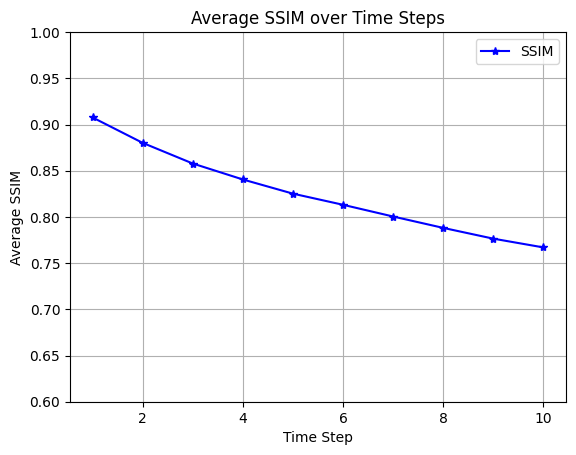

In [14]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import torch
from tqdm import tqdm

def calculate_average_ssim(model, data_loader, renorm_transform, num_future_frames, device='cuda:0'):
    model = model.to(device)
    model = model.eval()
    ave_ssim = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(tqdm(data_loader), 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            print(f"Prediction shape: {pred.shape}")  # Debug
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                pred_t = renorm_transform(pred_t)
                future_frames_t = renorm_transform(future_frames_t)

                ssim_value = ssim(pred_t.cpu().numpy(), future_frames_t.cpu().numpy(), win_size=3, multichannel=True, data_range=1.0, channel_axis=0)
                ave_ssim[i] += ssim_value * pred_t.shape[0]

            sample_num += pred.shape[0]

    ave_ssim = ave_ssim / sample_num
    return ave_ssim

num_future_frames = 10

# Assuming you have a test_loader and renorm_transform defined
average_ssim = calculate_average_ssim(
    model=model,
    data_loader=test_loader,
    renorm_transform=renorm_transform,
    num_future_frames=num_future_frames,  # Adjusted to match model output
    device='cuda:0'
)

# Plot SSIM results for the first 15 time steps (15 to 30)
#time_steps = np.arange(15, 31)  # Time steps from 15 to 30
time_steps = np.arange(1, 11)  # Time steps from 1 to 10
plt.plot(time_steps, average_ssim[:16], marker='*', linestyle='-', color='b', label='SSIM') # <--- Slice average_ssim to 16 values
plt.xlabel('Time Step')
plt.ylabel('Average SSIM')
plt.title('Average SSIM over Time Steps')
plt.ylim([0.6, 1.0]) 
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/43 [00:00<?, ?it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  2%|▏         | 1/43 [00:00<00:37,  1.12it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  5%|▍         | 2/43 [00:01<00:36,  1.14it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  7%|▋         | 3/43 [00:02<00:34,  1.15it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


  9%|▉         | 4/43 [00:03<00:34,  1.15it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 12%|█▏        | 5/43 [00:04<00:33,  1.15it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 14%|█▍        | 6/43 [00:05<00:31,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 16%|█▋        | 7/43 [00:06<00:30,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 19%|█▊        | 8/43 [00:06<00:30,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 21%|██        | 9/43 [00:07<00:29,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 23%|██▎       | 10/43 [00:08<00:28,  1.17it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 26%|██▌       | 11/43 [00:09<00:27,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 28%|██▊       | 12/43 [00:10<00:26,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 30%|███       | 13/43 [00:11<00:25,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 33%|███▎      | 14/43 [00:12<00:25,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 35%|███▍      | 15/43 [00:12<00:24,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 37%|███▋      | 16/43 [00:13<00:23,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 40%|███▉      | 17/43 [00:14<00:22,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 42%|████▏     | 18/43 [00:15<00:21,  1.15it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 44%|████▍     | 19/43 [00:16<00:20,  1.16it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 47%|████▋     | 20/43 [00:17<00:20,  1.15it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 49%|████▉     | 21/43 [00:18<00:19,  1.15it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 51%|█████     | 22/43 [00:19<00:20,  1.03it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 53%|█████▎    | 23/43 [00:20<00:19,  1.03it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 56%|█████▌    | 24/43 [00:21<00:17,  1.07it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 58%|█████▊    | 25/43 [00:22<00:16,  1.08it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 60%|██████    | 26/43 [00:22<00:15,  1.10it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 63%|██████▎   | 27/43 [00:24<00:15,  1.01it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 65%|██████▌   | 28/43 [00:25<00:17,  1.14s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 67%|██████▋   | 29/43 [00:26<00:14,  1.06s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 70%|██████▉   | 30/43 [00:27<00:13,  1.01s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 72%|███████▏  | 31/43 [00:28<00:13,  1.10s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 74%|███████▍  | 32/43 [00:29<00:11,  1.04s/it]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 77%|███████▋  | 33/43 [00:30<00:09,  1.02it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 79%|███████▉  | 34/43 [00:31<00:08,  1.06it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 81%|████████▏ | 35/43 [00:32<00:07,  1.09it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 84%|████████▎ | 36/43 [00:33<00:06,  1.00it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 86%|████████▌ | 37/43 [00:34<00:05,  1.01it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 88%|████████▊ | 38/43 [00:35<00:04,  1.05it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 91%|█████████ | 39/43 [00:36<00:03,  1.09it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 93%|█████████▎| 40/43 [00:36<00:02,  1.11it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 95%|█████████▌| 41/43 [00:37<00:01,  1.13it/s]

Prediction shape: torch.Size([32, 10, 3, 64, 64])


 98%|█████████▊| 42/43 [00:38<00:00,  1.14it/s]

Prediction shape: torch.Size([22, 10, 3, 64, 64])


100%|██████████| 43/43 [00:39<00:00,  1.10it/s]


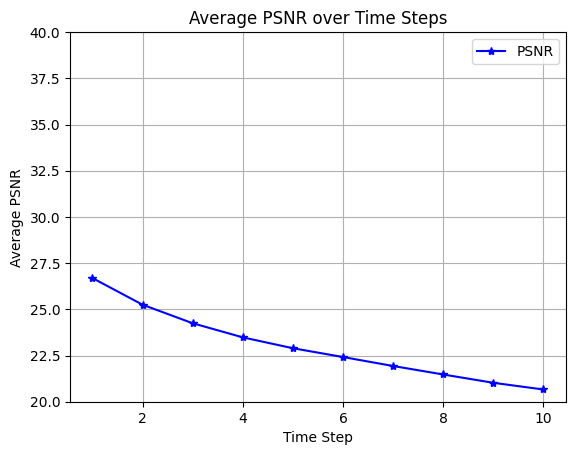

In [15]:
import numpy as np
from utils import PSNR
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def calculate_average_psnr(model, data_loader, renorm_transform, num_future_frames, device='cuda:0'):
    model = model.to(device)
    model = model.eval()
    ave_psnr = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(tqdm(data_loader), 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            print(f"Prediction shape: {pred.shape}")  # Debug
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                pred_t = renorm_transform(pred_t)
                future_frames_t = renorm_transform(future_frames_t)

                psnr_value = PSNR(pred_t, future_frames_t)
                ave_psnr[i] += psnr_value * pred_t.shape[0]

            sample_num += pred.shape[0]

    ave_psnr = ave_psnr / sample_num
    return ave_psnr

# Assuming you have a test_loader and renorm_transform defined
num_future_frames = 10 # <--- Set this to 10 to match time_steps
average_psnr = calculate_average_psnr(
    model=model,
    data_loader=test_loader,
    renorm_transform=renorm_transform,
    num_future_frames=num_future_frames,  # Use the same value here
    device='cuda:0'
)


# Assuming average_psnr contains your PSNR values and has the same length as the number of time steps
# Adjust the number of time steps based on your PSNR values
time_steps = np.arange(1, len(average_psnr) + 1)  # Adjust to match your PSNR data length

# Plot the PSNR results
plt.plot(time_steps, average_psnr, marker='*', linestyle='-', color='b', label='PSNR')
plt.xlabel('Time Step')
plt.ylabel('Average PSNR')
plt.title('Average PSNR over Time Steps')
plt.ylim([20, 40])  # Adjust the y-axis limit to a typical range for PSNR
plt.grid(True)
plt.legend()
plt.show()


In [22]:
import torch

def calculate_average_psnr(model, data_loader, renorm_transform, num_future_frames, device='cuda:0'):
    model = model.to(device)
    model = model.eval()
    ave_psnr = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(tqdm(data_loader), 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                pred_t = renorm_transform(pred_t)
                future_frames_t = renorm_transform(future_frames_t)

                psnr_value = calculate_psnr(pred_t.cpu().numpy(), future_frames_t.cpu().numpy())
                ave_psnr[i] += psnr_value * pred_t.shape[0]

            sample_num += pred.shape[0]

    ave_psnr = ave_psnr / sample_num
    return ave_psnr

# Assuming you have a test_loader and renorm_transform defined
average_psnr = calculate_average_psnr(
    model=model,
    data_loader=test_loader,
    renorm_transform=renorm_transform,
    num_future_frames=20,
    device='cuda:0'
)

# Plot PSNR results
plt.figure()
plt.plot(time_steps, average_psnr, label='PSNR', color='orange')
plt.xlabel('Time Step')
plt.ylabel('PSNR')
plt.title('Peak Signal-to-Noise Ratio')
plt.legend()
plt.show()


NameError: name 'model' is not defined

In [23]:
import numpy as np
from utils import PSNR, SSIM
import lpips

def pred_ave_metrics(model, data_loader, metric_func, renorm_transform, num_future_frames, num_past_frames, device = 'cuda:0', use_lpips = False, gray_scale = False):
    model = model.to(device)
    model = model.eval()
    ave_metric = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(data_loader, 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]
                
                if not use_lpips:
                    pred_t = renorm_transform(pred_t)
                    future_frames_t = renorm_transform(future_frames_t)
                elif use_lpips and gray_scale:
                    pred_t = pred_t.repeat(1, 3, 1, 1)
                    future_frames_t = future_frames_t.repeat(1, 3, 1, 1)
                    
                m = metric_func(pred_t, future_frames_t)*pred_t.shape[0]
                try:
                    ave_metric[i] += m.mean()
                except AttributeError:
                    ave_metric[i] += m
                
            sample_num += pred.shape[0]

    ave_metric = ave_metric / sample_num
    return ave_metric

In [24]:
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from utils import PSNR
import lpips

def pred_ave_metrics(model, data_loader, renorm_transform, num_future_frames, num_past_frames, device='cuda:0', use_lpips=False, gray_scale=False):
    model = model.to(device)
    model = model.eval()
    ave_metric = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(data_loader, 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]

                if not use_lpips:
                    pred_t = renorm_transform(pred_t)
                    future_frames_t = renorm_transform(future_frames_t)
                elif use_lpips and gray_scale:
                    pred_t = pred_t.repeat(1, 3, 1, 1)
                    future_frames_t = future_frames_t.repeat(1, 3, 1, 1)

                # Convert tensors to numpy arrays for SSIM calculation
                pred_np = pred_t.cpu().numpy().transpose(0, 2, 3, 1)
                future_np = future_frames_t.cpu().numpy().transpose(0, 2, 3, 1)

                # Calculate SSIM for each image in the batch
                ssim_values = []
                for j in range(pred_np.shape[0]):
                    ssim_value = ssim(pred_np[j], future_np[j], multichannel=True)
                    ssim_values.append(ssim_value)

                m = np.array(ssim_values) * pred_t.shape[0]
                try:
                    ave_metric[i] += m.mean()
                except AttributeError:
                    ave_metric[i] += m

            sample_num += pred.shape[0]

    ave_metric = ave_metric / sample_num
    return ave_metric

In [25]:
encoder = VPTR_Enc
decoder = VPTR_Dec

In [26]:
class VPTRModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(VPTRModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, past_frames):
        encoded_feats = self.encoder(past_frames)
        pred_frames = self.decoder(encoded_feats)
        return pred_frames

In [27]:
# Create the combined model
model = VPTRModel(encoder, decoder)

SSIM is a widely used metric for image quality assessment. It is based on the computation of the similarity between two images. The SSIM value ranges from -1 to 1, where 1 indicates the highest similarity between the two images. In this notebook, we will test the trained VPTR model on the test dataset and calculate the SSIM value between the predicted and ground truth images.

In [43]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Define a suitable window size
win_size = 3

# Use the pred_ave_metrics function to measure SSIM
average_metrics = pred_ave_metrics(
    model=model,
    data_loader=test_loader,
    metric_func=lambda x, y: ssim(x.cpu().numpy(), y.cpu().numpy(), win_size=win_size, multichannel=True, data_range=1.0),  # Convert tensors to NumPy arrays and specify data_range
    renorm_transform=renorm_transform,
    num_future_frames=2,
    num_past_frames=10,
    device='cuda:0',
    use_lpips=False,
    gray_scale=True
)

In [44]:
print(average_metrics)

[0.88832196 0.88686032]


In [14]:
# Use the pred_ave_metrics function
average_metrics = pred_ave_metrics(
    model=model,
    data_loader=test_loader,
    metric_func=PSNR,
    renorm_transform=renorm_transform,
    num_future_frames=2,
    num_past_frames=10,
    device='cuda:0',
    use_lpips=False,
    gray_scale=True
)

In [15]:
print(average_metrics)

[24.68457899 24.65911371]


In [ ]:
import numpy as np
from utils import PSNR, SSIM
import lpips

def pred_ave_metrics(model, data_loader, metric_func, renorm_transform, num_future_frames, num_past_frames, device = 'cuda:0', use_lpips = False, gray_scale = True):
    model = model.to(device)
    model = model.eval()
    ave_metric = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(data_loader, 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]
                
                if not use_lpips:
                    pred_t = renorm_transform(pred_t)
                    future_frames_t = renorm_transform(future_frames_t)
                elif use_lpips and gray_scale:
                    pred_t = pred_t.repeat(1, 3, 1, 1)
                    future_frames_t = future_frames_t.repeat(1, 3, 1, 1)
                    
                m = metric_func(pred_t, future_frames_t)*pred_t.shape[0]
                try:
                    ave_metric[i] += m.mean()
                except AttributeError:
                    ave_metric[i] += m
                
            sample_num += pred.shape[0]

    ave_metric = ave_metric / sample_num
    return ave_metric

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

def compute_metrics(predictions, ground_truths):
	psnr_values = []
	ssim_values = []
	time_steps = [15, 20, 25, 30]
	models = ['MCnet', 'SVG-LP', 'SVG-LP*', 'ML-VAE', 'TPG-VAE']

	results = {model: {t: {'psnr': [], 'ssim': []} for t in time_steps} for model in models}
	
	for model in models:
		for t in time_steps:
			predictions = ...  # Load or generate predictions for the model at time step t
			ground_truths = ...  # Load ground truth images
			mean_psnr, std_psnr, mean_ssim, std_ssim = compute_metrics(predictions, ground_truths)
			results[model][t]['psnr'] = (mean_psnr, std_psnr)
			results[model][t]['ssim'] = (mean_ssim, std_ssim)
	
	table_data = []
	for model in results:
		row = [model]
		for t in time_steps:
			psnr_mean, psnr_std = results[model][t]['psnr']
			ssim_mean, ssim_std = results[model][t]['ssim']
			row.append(f'{psnr_mean:.2f}±{psnr_std:.2f}')
			row.append(f'{ssim_mean:.3f}±{ssim_std:.3f}')
		table_data.append(row)
	
	columns = ['Model'] + [f'PSNR t={t}' for t in time_steps] + [f'SSIM t={t}' for t in time_steps]
	df = pd.DataFrame(table_data, columns=columns)
	print(df.to_string(index=False))
	return np.mean(psnr_values), np.std(psnr_values), np.mean(ssim_values), np.std(ssim_values)

import matplotlib.pyplot as plt

def plot_metrics(results, metric_name):
	plt.figure(figsize=(10, 6))
	for model in results:
		time_steps = sorted(results[model].keys())
		means = [results[model][t][metric_name][0] for t in time_steps]
		stds = [results[model][t][metric_name][1] for t in time_steps]
		plt.errorbar(time_steps, means, yerr=stds, label=model, capsize=5)
	plt.xlabel('Time Step')
	plt.ylabel(metric_name)
	plt.legend()
	plt.title(f'{metric_name} over Time Steps')
	plt.show()

plot_metrics(results, 'psnr')
plot_metrics(results, 'ssim')